In [1]:
import re
import sys
import numpy as np
import pandas as pd
import pickle
from pymagnitude import *
import matplotlib.pyplot as plt
%matplotlib inline
import gc
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import RNN, GRU, LSTM, Dense, Input, Embedding, Dropout, Activation, concatenate
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import Callback, ReduceLROnPlateau
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import pandas as pd
import os
import nltk
import re
from bs4 import BeautifulSoup
import urllib3
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn import preprocessing
from scipy import sparse
from keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from keras.layers import Input, Dense # Layers to be used for building our model
from keras.models import Model # The class used to create a model
from keras.optimizers import Adam
from keras.utils import np_utils # Utilities to manipulate numpy arrays
from tensorflow import set_random_seed # Used for reproducible experiments
from tensorflow import keras
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.layers import InputLayer, Input, Embedding, Dense, Dropout, Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, SpatialDropout1D, Conv1D, CuDNNLSTM, CuDNNGRU, TimeDistributed, Reshape, Permute, LocallyConnected1D, concatenate, ELU, Activation, add, Lambda, BatchNormalization, PReLU, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras import regularizers
#from kgutil.models.keras.base import DefaultTrainSequence, DefaultTestSequence
#from kgutil.models.keras.rnn import KerasRNN, load_emb_matrix
from copy import deepcopy
import inspect
import tensorflow as tf

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Concatenate, Conv1D, Activation, TimeDistributed, Flatten, RepeatVector, Permute,multiply
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, GRU, GlobalAveragePooling1D, MaxPooling1D, SpatialDropout1D, BatchNormalization
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re,gc
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,log_loss
import os

/opt/conda/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/allennlp/commands/find_learning_rate.py:55: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')
Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')

classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_data[classes].values

train_sentences = train_data["comment_text"].fillna("fillna").str.lower()
test_sentences = test_data["comment_text"].fillna("fillna").str.lower()

max_features = 150000
max_len = 150
embed_size = 600

tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(list(train_sentences))

tokenized_train_sentences = tokenizer.texts_to_sequences(train_sentences)
tokenized_test_sentences = tokenizer.texts_to_sequences(test_sentences)

train_padding = pad_sequences(tokenized_train_sentences, max_len)
test_padding = pad_sequences(tokenized_test_sentences, max_len)

#https://github.com/plasticityai/magnitude
#!curl -s http://magnitude.plasticity.ai/glove+subword/glove.6B.300d.magnitude --output vectors.magnitude

#vecs_word2vec = Magnitude('http://magnitude.plasticity.ai/word2vec/heavy/GoogleNews-vectors-negative300.magnitude', stream=True, pad_to_length=max_len) 
vecs_glove = Magnitude('http://magnitude.plasticity.ai/glove+subword/glove.6B.300d.magnitude')
vecs_fasttext = Magnitude('http://magnitude.plasticity.ai/fasttext+subword/wiki-news-300d-1M.magnitude', pad_to_length=max_len)
#vecs_elmo = Magnitude('http://magnitude.plasticity.ai/elmo/medium/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.magnitude', stream=True, pad_to_length=max_len)

vectors = Magnitude(vecs_fasttext, vecs_glove) # concatenate word2vec with glove
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, vectors.dim))

from tqdm import tqdm_notebook as tqdm
for word, i in tqdm(word_index.items()):
    if i >= max_features:
        continue
    embedding_vector = vectors.query(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.uniform(-0.25, 0.25, embed_size)

gc.collect()

In [3]:
# https://www.kaggle.com/yekenot/pooled-gru-fasttext

#Define a class for model evaluation
class RocAucEvaluation(Callback):
    def __init__(self, training_data=(),validation_data=()):
        super(Callback, self).__init__()
       
        self.X_tra, self.y_tra = training_data
        self.X_val, self.y_val = validation_data
        self.aucs_val = []
        self.aucs_tra = []
        
    def on_epoch_end(self, epoch, logs={}):                   
        y_pred_val = self.model.predict(self.X_val, verbose=0)
        score_val = roc_auc_score(self.y_val, y_pred_val)

        y_pred_tra = self.model.predict(self.X_tra, verbose=0)
        score_tra = roc_auc_score(self.y_tra, y_pred_tra)

        self.aucs_tra.append(score_val)
        self.aucs_val.append(score_tra)
        print("\n ROC-AUC - epoch: %d - score_tra: %.6f - score_val: %.6f \n" % (epoch+1, score_tra, score_val))

def recall(y_true, y_pred):    
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):    
    """
    Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

In [4]:
class Plots:
    def plot_history(history):
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        x = range(1, len(val_loss) + 1)

        plt.plot(x, loss, 'b', label='Training loss')
        plt.plot(x, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

    def plot_roc_auc(train_roc, val_roc):
        x = range(1, len(val_roc) + 1)

        plt.plot(x, train_roc, 'b', label='Training RocAuc')
        plt.plot(x, val_roc, 'r', label='Validation RocAuc')
        plt.title('Training and validation RocAuc')
        plt.legend()

In [5]:
X_tra, X_val, y_tra, y_val = train_test_split(train_padding, y, train_size=0.95, random_state=233)
RocAuc = RocAucEvaluation(training_data=(X_tra, y_tra) ,validation_data=(X_val, y_val))

### SIMPLE CNN TEXT

In [6]:
max_size=150
optimizer = Adam(lr=0.001) # , beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# optimizer = Adam(lr=0.008)
reducer_lr = ReduceLROnPlateau(factor = 0.00005, patience = 1, min_lr = 1e-6, verbose = 1)

my_input = Input(shape=(max_size, ))

embedding = Embedding(input_dim=max_features,
                      output_dim=600,
                      weights=[embedding_matrix],
                      trainable=False,
                      input_length=max_size
                      ) (my_input)

conv1 = Conv1D(filters=150,
               kernel_size=2,
               activation = 'relu',
#                kernel_regularizer=l2(0.0001),
#                bias_regularizer=l2(0.0001)
               ) (embedding)

conv2 = Conv1D(filters=150,
               kernel_size=3,
               activation = 'relu',
#                kernel_regularizer=l2(0.0001),
#                bias_regularizer=l2(0.0001)
               ) (embedding)

conv3 = Conv1D(filters=150,
               kernel_size=4,
               activation = 'relu',
#                kernel_regularizer=l2(0.0001),
#                bias_regularizer=l2(0.0001)
               ) (embedding)

pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)
pool3 = GlobalMaxPooling1D()(conv3)
concat = Concatenate()([pool1, pool2, pool3])
drop = Dropout(rate=0.5) (concat)

my_output = Dense(units=6, activation='sigmoid')(drop)

model_CNN = Model(my_input, my_output)
model_CNN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_crossentropy'])
model_CNN.summary()

# go through epochs as long as accuracy on validation set increases
early_stopping = EarlyStopping(monitor='val_binary_crossentropy', 
                               patience=5,
                               mode='min')

# make sure that the model corresponding to the best epoch is saved
checkpointer = ModelCheckpoint(filepath='cnn_text_categorization.hdf5',
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=0)


model_CNN.fit(X_tra,
          y_tra,
          epochs=50,
          batch_size=128,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping, RocAuc, checkpointer, reducer_lr]
      )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 600)     90000000    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 149, 150)     180150      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 148, 150)     270150      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from IPython.display import HTML

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
# Image(retina=True, filename='model.png')

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='model.png')

NameError: name 'model' is not defined

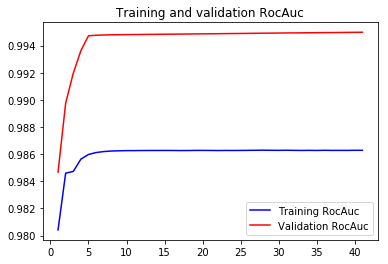

In [8]:
# model.summary() # Print a description of the model.
Plots.plot_roc_auc(RocAuc.aucs_tra, RocAuc.aucs_val)
# Plots.plot_history(model_CNN.history)

In [9]:
index_to_word = dict(map(reversed, word_index.items()))

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


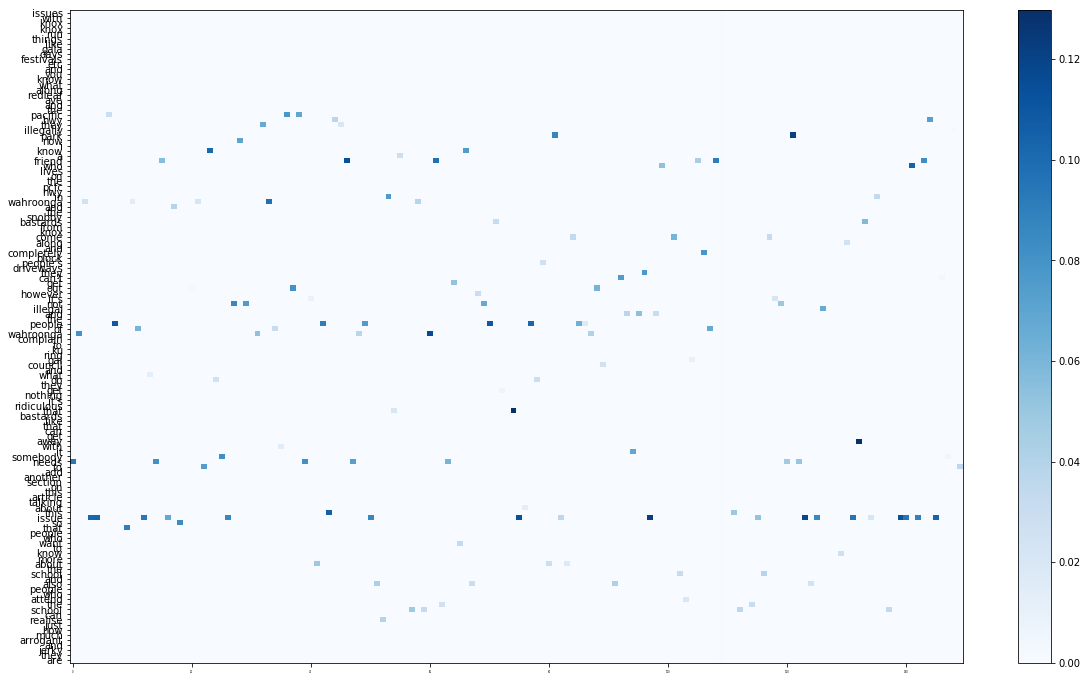

In [10]:
input_tensors = [model_CNN.input, K.learning_phase()]
saliency_input = model_CNN.layers[3].output # before split into branches
saliency_output = model_CNN.layers[10].output # class score
gradients = model_CNN.optimizer.get_gradients(saliency_output,saliency_input)
compute_gradients = K.function(inputs=input_tensors,outputs=gradients)

for idx,doc in enumerate(X_tra):
    if idx==10:
        matrix = compute_gradients([np.array([doc]),0])[0][0,:,:]
        tokens = [index_to_word[elt] for elt in doc if elt!=0]
        to_plot = np.absolute(matrix[:len(tokens),:])
        fig, ax = plt.subplots()
        heatmap = ax.imshow(to_plot, cmap=plt.cm.Blues, interpolation='nearest',aspect='auto')
        ax.set_yticks(np.arange(len(tokens)))
        ax.set_yticklabels(tokens)
        ax.tick_params(axis='x', which='major', labelsize=32*10/len(tokens))
        fig.colorbar(heatmap)
        fig.set_size_inches(20,12)   
        fig.show()
        break

## Deep Pyramid CNN

In [11]:
def dpcnn(    
    target_shape,
    optimizer,
    max_len=max_len,    
    max_features=max_features,    
    filter_nr=64,
    filter_size=3,
    max_pool_size=3,
    max_pool_strides=2,
    dense_nr=256,
    spatial_dropout=0.2,
    dense_dropout=0.5,    
    lr=1e-3,
    text_emb_dropout=0.2, text_emb_size=embed_size, emb_weights=[embedding_matrix], text_emb_trainable=False, text_emb_rand_std=None
):


    text_inp = Input(shape=[max_len], name='comment_text')
    inputs = [text_inp]

    emb = Embedding(max_features, text_emb_size, weights=emb_weights, trainable=text_emb_trainable)(text_inp)
    emb = SpatialDropout1D(text_emb_dropout)(emb)

    conv_kern_reg = regularizers.l2(0.00001)
    conv_bias_reg = regularizers.l2(0.00001)

    block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb)
    block1 = BatchNormalization()(block1)
    block1 = PReLU()(block1)
    block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1)
    block1 = BatchNormalization()(block1)
    block1 = PReLU()(block1)

    #we pass embedded comment through conv1d with filter size 1 because it needs to have the same shape as block output
    #if you choose filter_nr = embed_size (300 in this case) you don't have to do this part and can add emb_comment directly to block1_output
    resize_emb = Conv1D(filter_nr, kernel_size=1, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb)
    resize_emb = PReLU()(resize_emb)

    block1_output = add([block1, resize_emb])
    block1_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output)

    block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1_output)
    block2 = BatchNormalization()(block2)
    block2 = PReLU()(block2)
    block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2)
    block2 = BatchNormalization()(block2)
    block2 = PReLU()(block2)

    block2_output = add([block2, block1_output])
    block2_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output)

    block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2_output)
    block3 = BatchNormalization()(block3)
    block3 = PReLU()(block3)
    block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3)
    block3 = BatchNormalization()(block3)
    block3 = PReLU()(block3)

    block3_output = add([block3, block2_output])
    block3_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block3_output)

    block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3_output)
    block4 = BatchNormalization()(block4)
    block4 = PReLU()(block4)
    block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4)
    block4 = BatchNormalization()(block4)
    block4 = PReLU()(block4)

    block4_output = add([block4, block3_output])
    block4_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block4_output)

    block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4_output)
    block5 = BatchNormalization()(block5)
    block5 = PReLU()(block5)
    block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5)
    block5 = BatchNormalization()(block5)
    block5 = PReLU()(block5)

    block5_output = add([block5, block4_output])
    block5_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block5_output)

    block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5_output)
    block6 = BatchNormalization()(block6)
    block6 = PReLU()(block6)
    block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6)
    block6 = BatchNormalization()(block6)
    block6 = PReLU()(block6)

    block6_output = add([block6, block5_output])
    block6_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block6_output)

    block7 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6_output)
    block7 = BatchNormalization()(block7)
    block7 = PReLU()(block7)
    block7 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block7)
    block7 = BatchNormalization()(block7)
    block7 = PReLU()(block7)

    block7_output = add([block7, block6_output])
    output = GlobalMaxPooling1D()(block7_output)

    output = Dense(dense_nr, activation='linear')(output)
    output = BatchNormalization()(output)
    output = PReLU()(output)
    output = Dropout(dense_dropout)(output)
    output = Dense(6, activation='sigmoid')(output)

    # Model
    model = Model(inputs, output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

In [12]:
model = dpcnn(
    max_len=max_len,
    target_shape=(6,1),
    max_features=max_features,    
    filter_nr=64,
    filter_size=3,
    max_pool_size=3,
    max_pool_strides=2,
    dense_nr=256,
    spatial_dropout=0.2,
    dense_dropout=0.5,
    optimizer=Adam(lr=1e-3),
    text_emb_dropout=0.2,
    text_emb_size=embed_size,
    emb_weights=[embedding_matrix],
    text_emb_trainable=False,
    text_emb_rand_std=None
)


# go through epochs as long as accuracy on validation set increases
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,
                               mode='min')

# make sure that the model corresponding to the best epoch is saved
checkpointer = ModelCheckpoint(filepath='cnn_text_categorization.hdf5',
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=0)


model.fit(X_tra,
          y_tra,
          epochs=50,
          batch_size=256,
          shuffle=True,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping, RocAuc, checkpointer]
      )

Train on 151592 samples, validate on 7979 samples
Epoch 1/50
151592/151592 [==============================] - 28s 186us/step - loss: 0.0926 - val_loss: 0.0628

 ROC-AUC - epoch: 1 - score_tra: 0.974214 - score_val: 0.969469 

Epoch 2/50
151592/151592 [==============================] - 22s 147us/step - loss: 0.0585 - val_loss: 0.0571

 ROC-AUC - epoch: 2 - score_tra: 0.978482 - score_val: 0.974009 

Epoch 3/50
151592/151592 [==============================] - 23s 149us/step - loss: 0.0549 - val_loss: 0.0643

 ROC-AUC - epoch: 3 - score_tra: 0.979748 - score_val: 0.974208 

Epoch 4/50
151592/151592 [==============================] - 22s 147us/step - loss: 0.0525 - val_loss: 0.0555

 ROC-AUC - epoch: 4 - score_tra: 0.983044 - score_val: 0.977156 

Epoch 5/50
151592/151592 [==============================] - 22s 147us/step - loss: 0.0500 - val_loss: 0.0552

 ROC-AUC - epoch: 5 - score_tra: 0.983187 - score_val: 0.976382 

Epoch 6/50
151592/151592 [==============================] - 23s 149us/

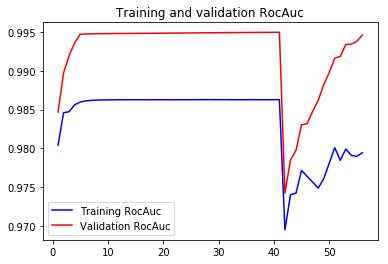

In [13]:
# model.summary() # Print a description of the model.
Plots.plot_roc_auc(RocAuc.aucs_tra, RocAuc.aucs_val)
# Plots.plot_history(model.history)

In [14]:
K.clear_session()
del model
gc.collect()

2554